In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

## Functions

In [2]:
def reproject(latitude, longitude):
    """Returns the x & y coordinates in meters using a sinusoidal projection"""
    from math import pi, cos, radians
    earth_radius = 6371009 # in meters
    lat_dist = pi * earth_radius / 180.0

    y = [lat * lat_dist for lat in latitude]
    x = [long * lat_dist * cos(radians(lat)) 
                for lat, long in zip(latitude, longitude)]
    return x, y

def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

def mean_point(x, y):
    centroid = (sum(x) / len(x), sum(y) / len(y))
    return centroid

## FORWARD

In [3]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")

In [4]:
start_date = datetime(2023,1,4,15,12,8)  # first day of deployment/you want to run from 
end_date = datetime(2023,3,10,15,12,8)   # first day of last simulation
time_delta = timedelta(days=5)           # 5 days
duration = timedelta(hours=48)           # 2 days

start_time = [] 
end_time = []

while (start_date <= end_date):
    start_date += time_delta
    start_time.append(start_date)
    end_time.append(start_date + duration)

In [141]:
outfile = []
for i in range(len(start_time)):
    outfile.append("D:/backtrack/oceandrift_48h/fwd_randompick_area_"+str(i)+".nc")

### Random area range

In [142]:
lons = np.arange(34, 36, .1/4) 
lats = np.arange(-36, -34, .05/4)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

In [7]:
for i in range(len(start_time)):
    ofwd = OceanDrift(loglevel=50)
    ofwd.add_reader([reader_globcur])
    ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time[i])
    ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile[i])

In [143]:
fwd = []
for f in outfile: 
    fwd.append(xr.open_dataset(f))

In [144]:
traj = np.arange(0,len(fwd[i].trajectory),1)

In [10]:
### Calculating lons and lats for the end of the trajectories ### 
lon = []
lat = []
lonend = []
latend = []
for i in range(len(start_time)):
    for j in range(len(fwd[i].trajectory)):
        lon.append(fwd[i].isel(trajectory=j).lon.values)
        lat.append(fwd[i].isel(trajectory=j).lat.values)
        lonend.append(fwd[i].isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend.append(fwd[i].isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(fwd[i].trajectory))

In [13]:
lon

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,34.000000,34.010101,34.020695,34.031803,34.043446,34.055653,34.068439,34.081837,34.095871,34.110569,...,34.737572,34.758606,34.779472,34.799805,34.819187,34.837658,34.855255,34.871830,34.887341,34.901962
1,34.025002,34.035820,34.047161,34.059044,34.071495,34.084534,34.098190,34.112484,34.127449,34.142990,...,34.770210,34.790226,34.809769,34.828403,34.846161,34.863083,34.879196,34.894470,34.908878,34.922451
2,34.049999,34.061535,34.073620,34.086281,34.099537,34.113415,34.127937,34.143017,34.158577,34.174606,...,34.799316,34.818157,34.836151,34.853298,34.869640,34.885231,34.900230,34.914497,34.927940,34.940598
3,34.075001,34.087254,34.100086,34.113525,34.127586,34.142208,34.157314,34.172894,34.188946,34.205452,...,34.825260,34.842701,34.859325,34.875172,34.890335,34.904942,34.919014,34.932396,34.944996,34.956844
4,34.099998,34.112968,34.126549,34.140694,34.155338,34.170464,34.186069,34.202145,34.218678,34.235657,...,34.848259,34.864437,34.879860,34.894672,34.908943,34.922695,34.935947,34.948547,34.960396,34.971531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179195,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,...,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000,35.875000
179196,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,...,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002,35.900002
179197,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,...,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999,35.924999
179198,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,...,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001,35.950001


In [13]:
lon = pd.DataFrame(lon)
lat = pd.DataFrame(lat)

In [14]:
lon.to_pickle('lon_area_time_fwd.pkl')
lat.to_pickle('lat_area_time_fwd.pkl')
np.savetxt('lonend_area_time_fwd.out', lonend, delimiter=',')
np.savetxt('latend_area_time_fwd.out', latend, delimiter=',')

In [145]:
lon = pd.read_pickle('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/Multiple_dates/lon_area_time_fwd.pkl')
lat = pd.read_pickle('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/Multiple_dates/lat_area_time_fwd.pkl')
lonend = np.loadtxt('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/Multiple_dates/lonend_area_time_fwd.out')
latend = np.loadtxt('C:/Users/bente/Documents/BACKTRACK/pick_random_fwd_as_truth_oceandrift_48h/Multiple_dates/latend_area_time_fwd.out')

In [146]:
n = []
sepdis_fwd = []
area_fwd = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []
for j in range(len(start_time)):
    for i in range(10):
        a = np.random.choice(traj)
        a_traj.append(a)
        iloni = fwd[j].isel(trajectory=a).lon.values[-1]
        ilon.append(iloni)
        ilati = fwd[j].isel(trajectory=a).lat.values[-1]
        ilat.append(ilati)
        startloni = fwd[j].isel(trajectory=a).lon.values[0]
        startlon.append(startloni)
        startlati = fwd[j].isel(trajectory=a).lat.values[0]
        startlat.append(startlati)
        if iloni<1e10 and ilati<1e10:
            geod = pyproj.Geod(ellps='WGS84')
            on = np.ones(len(lonend[(j)*7200:(j+1)*7200]))
            dummy1, dummy2, dist2incident = geod.inv(lonend[(j)*7200:(j+1)*7200], latend[(j)*7200:(j+1)*7200], iloni*on, ilati*on)
            ran = np.arange((j)*7200,(j+1)*7200)
            hits = ran[dist2incident<5000]
#             hits = pd.DataFrame(np.where(dist2incident<5000))
            if len(hits)>0:
                lenhits = len(hits)
                n.append(lenhits) 

                hit_start_lons = []
                hit_start_lats = []
                for m in range(lenhits):
                    hit_start_lons.append(np.array(lon[(j)*7200:(j+1)*7200].loc[hits[m]][0]))
                    hit_start_lats.append(np.array(lat[(j)*7200:(j+1)*7200].loc[hits[m]][0]))

                ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
                if len(hit_start_lons)>1: 
                    centroid_fwd = mean_point(hit_start_lons, hit_start_lats)
                    sepdis_fwd.append(ta.skill.distance_between_trajectories(np.array([startloni]), np.array([startlati]), np.array([centroid_fwd[0]]), np.array([centroid_fwd[1]])))
                else:
                    sepdis_fwd.append(np.nan)

                ### calculating area of convex hull ###
                if lenhits>2 and hit_start_lons.count(hit_start_lons[0]) is not len(hit_start_lons) and hit_start_lats.count(hit_start_lats[0]) is not len(hit_start_lats):
                    points = []
                    for k in range(lenhits):
                        points.append([hit_start_lons[k], hit_start_lats[k]])
                    points = np.array(points)
                    reshaped_points = points.reshape(-1, 2)
                    hull_fwd = ConvexHull(reshaped_points)
                    hull_fwd_points = points[hull_fwd.vertices]

                    hull_fwd_lon = []
                    hull_fwd_lat = []
                    for l in range(len(hull_fwd_points)):
                        hull_fwd_lon.append(hull_fwd_points[l,0])
                        hull_fwd_lat.append(hull_fwd_points[l,1])
                    repro_fwd = reproject(hull_fwd_lon, hull_fwd_lat)
                    area_fwd.append(area_of_polygon(repro_fwd[0],repro_fwd[1]))
                else: 
                    area_fwd.append(np.nan)
            else: 
                n.append(np.nan)
                sepdis_fwd.append(np.nan)
                area_fwd.append(np.nan)
        else: 
            n.append(np.nan)
            sepdis_fwd.append(np.nan)
            area_fwd.append(np.nan)

In [148]:
sepdis_fwd

[array([1512.68920618]),
 nan,
 array([2826.50793838]),
 nan,
 array([586.86164062]),
 nan,
 array([2078.62287867]),
 nan,
 array([1367.08928761]),
 array([0.15418116]),
 array([20468.66968443]),
 array([25625.37298497]),
 nan,
 array([1209.68909639]),
 array([24498.44476989]),
 array([24889.98317507]),
 array([33301.19164476]),
 array([20045.77681969]),
 nan,
 nan,
 nan,
 array([40019.33770167]),
 array([10026.5240263]),
 array([19531.43635737]),
 nan,
 array([16679.26453653]),
 nan,
 array([53755.947449]),
 array([6981.35763777]),
 nan,
 nan,
 nan,
 nan,
 nan,
 array([57626.11345263]),
 array([62377.27852847]),
 nan,
 nan,
 nan,
 array([19114.35204219]),
 nan,
 array([47968.87211168]),
 array([92919.47237142]),
 array([42379.18319819]),
 nan,
 nan,
 array([66045.30716928]),
 nan,
 array([85223.60733247]),
 array([55773.42213005]),
 nan,
 array([3607.43548254]),
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 array([50762.55064244]),
 nan,
 array([61974.79408235]),
 nan,
 array([44013.35641689])

In [140]:
startloni

34.5

In [106]:
startlati

-34.5625

In [44]:
lon[0]

0         34.000000
1         34.025002
2         34.049999
3         34.075001
4         34.099998
            ...    
179195    35.875000
179196    35.900002
179197    35.924999
179198    35.950001
179199    35.974998
Name: 0, Length: 179200, dtype: float32

### BACKWARD

In [149]:
outfile_back = []
for j in range(len(start_time)):
    for i in range(10):
        outfile_back.append("D:/backtrack/oceandrift_48h/random_pick/back_time_area4_t"+str(j)+"_"+str(i)+".nc")

In [150]:
for j in range(len(start_time)):
    for i in range(10):
        orev = OceanDrift(loglevel=50)
        orev.add_reader([reader_globcur])
        if n[i+(10*j)]>0 and ilon[i+(10*j)]<1e10 and ilat[i+(10*j)]<1e10:
            orev.seed_elements(lon=ilon[i+(10*j)], lat=ilat[i+(10*j)], radius=5000, radius_type='uniform', number=n[i+(10*j)],
                             time=end_time[j])
            orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_back[i+(10*j)])

In [151]:
sims_back = []
for j in range(len(start_time)):
    for i in range(10):
        if n[i+(10*j)]>0 and ilon[i+(10*j)]<1e10 and ilat[i+(10*j)]<1e10:
            sims_back.append(xr.open_dataset(outfile_back[i+(10*j)]))     # For the forward runs with hits
        else: 
            sims_back.append(np.nan)                               # For the forward runs without hits

In [176]:
len(sims_back[0])

28

In [153]:
area_back = []
sepdis_back = []

for j in range(len(start_time)):
    for i in range(10):
        if sims_back[i+(10*j)]>0:
            lon = []
            lat = []
            lonend = []
            latend = []
            for b in range(len(sims_back[i+(10*j)].trajectory)):
                lon.append(sims_back[i+(10*j)].isel(trajectory=b).lon.values)
                lat.append(sims_back[i+(10*j)].isel(trajectory=b).lat.values)
                lonend.append(sims_back[i+(10*j)].isel(trajectory=b).lon.values[-1])   # lon at end of trajectory
                latend.append(sims_back[i+(10*j)].isel(trajectory=b).lat.values[-1])   # lat at end of trajectory

            ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
            if len(lonend)>1 and len(lonend)<400: 
                centroid_back = mean_point(lonend, latend)
                sepdis_back.append(ta.skill.distance_between_trajectories(np.array([startlon[i+(10*j)]]), np.array([startlat[i+(10*j)]]), np.array([centroid_back[0]]), np.array([centroid_back[1]])))

                ### calculating area of convex hull ###
                points_back = []
                for k in range(len(lonend)):
                    if lonend[k]<1e10 and latend[k]<1e10:
                        points_back.append([lonend[k], latend[k]])
                points_back = np.array(points_back)

                if len(points_back)>2: 
                    hull_back = ConvexHull(points_back)
                    hull_back_points = points_back[hull_back.vertices]
                    hull_back_lon = []
                    hull_back_lat = []
                    for l in range(len(hull_back_points)):
                        hull_back_lon.append(hull_back_points[l,0])
                        hull_back_lat.append(hull_back_points[l,1])

                    repro_back = reproject(hull_back_lon, hull_back_lat)
                    area_back.append(area_of_polygon(repro_back[0],repro_back[1]))

            else:
                area_back.append(np.nan)
                sepdis_back.append(np.nan)

        else:
            area_back.append(np.nan)
            sepdis_back.append(np.nan)

In [154]:
sepdis_back

[array([478.10472295]),
 nan,
 array([647.10258056]),
 nan,
 array([237.97302651]),
 nan,
 array([571.91743414]),
 nan,
 array([985.12142407]),
 array([488.77848662]),
 array([524.2455667]),
 array([646.93993383]),
 nan,
 array([198.1807079]),
 array([765.27547463]),
 array([1562.82243143]),
 array([804.97717728]),
 array([349.27456857]),
 nan,
 nan,
 nan,
 array([729.47981758]),
 array([260.23637034]),
 array([355.01897226]),
 nan,
 array([906.44960041]),
 nan,
 array([1790.43406273]),
 array([832.48472815]),
 nan,
 nan,
 nan,
 nan,
 nan,
 array([348.04015738]),
 array([745.9926732]),
 nan,
 nan,
 nan,
 array([252.50778358]),
 nan,
 array([1227.88799021]),
 array([1473.82177019]),
 array([170.22784295]),
 nan,
 nan,
 array([298.60440534]),
 nan,
 array([777.76488831]),
 array([856.8918406]),
 nan,
 array([510.66468347]),
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 array([1574.8457988]),
 nan,
 array([476.33391298]),
 nan,
 array([682.92205766]),
 array([251.77903624]),
 array([187.2954347]),

In [155]:
sepdis_fwd_new = []
sepdis_back_new = []
for i in range(len(sepdis_fwd)):
    if sepdis_fwd[i] is not np.nan: 
        sepdis_fwd_new.append(sepdis_fwd[i][0])
    else: 
        sepdis_fwd_new.append(np.nan)
    if sepdis_back[i] is not np.nan: 
        sepdis_back_new.append(sepdis_back[i][0])
    else: 
        sepdis_back_new.append(np.nan)

In [156]:
np.savetxt('area_time_area_forward.out', area_fwd, delimiter=',')
np.savetxt('area_time_sepdis_fwd.out', sepdis_fwd_new, delimiter=',')
np.savetxt('area_time_area_back.out', area_back, delimiter=',')
np.savetxt('area_time_sepdis_back.out', sepdis_back_new, delimiter=',')
np.savetxt('area_time_n.out', n, delimiter=',')

Text(0.5, 1.0, 'Area convex hull')

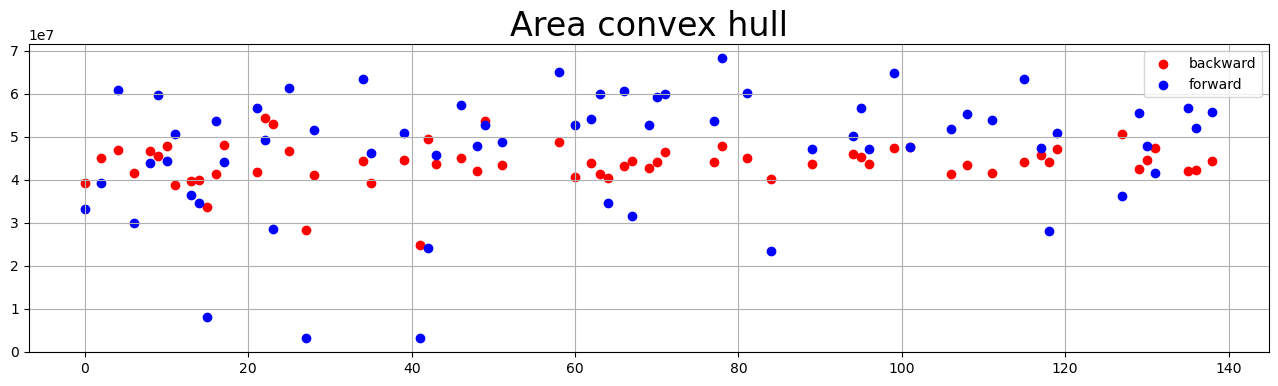

In [157]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(area_back)), area_back, color='red', linestyle='-', label='backward')
plt.scatter(range(len(area_fwd)), area_fwd, color='blue', linestyle='-', label='forward')

#plt.ylim([-10000000,2e8])
plt.legend()
plt.grid()
plt.title('Area convex hull', fontsize=24)

(-10000000.0, 100000000.0)

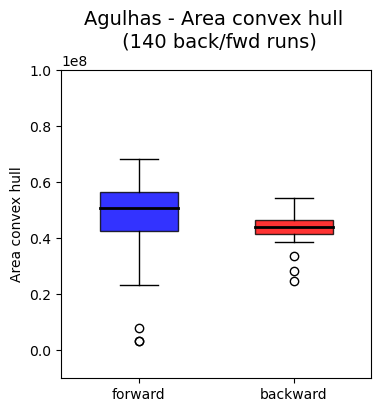

In [158]:
area_back_nan = np.array(area_back)[~np.isnan(np.array(area_back))]
area_forward_nan = np.array(area_fwd)[~np.isnan(np.array(area_fwd))]

plt.figure(figsize=(4,4))
plt.boxplot(area_back_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(area_forward_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Area convex hull')
plt.title('Agulhas - Area convex hull \n (140 back/fwd runs)', fontsize=14)

plt.ylim([-1e7,1e8])

(0.0, 30000.0)

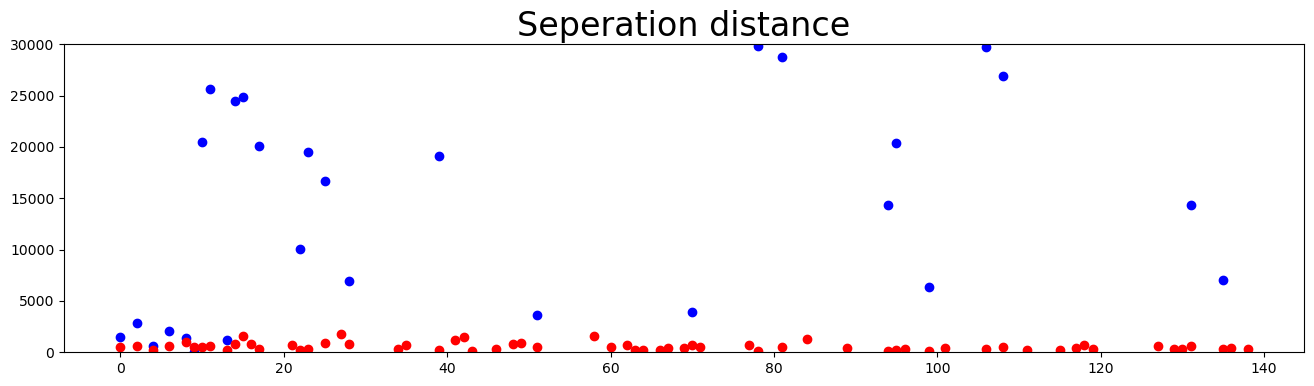

In [174]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(sepdis_fwd_new)),sepdis_fwd_new, color='blue')
plt.scatter(range(len(sepdis_back_new)),sepdis_back_new, color='red')
plt.title('Seperation distance', fontsize=24)
plt.ylim([0,30000])

Text(0.5, 1.0, 'Seperation distance')

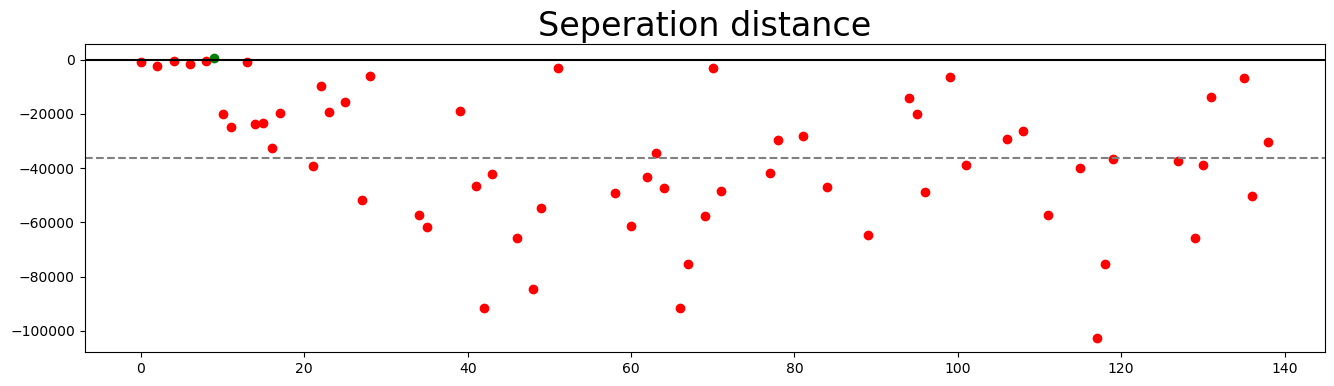

In [160]:
dif = np.array(sepdis_back_new) - np.array(sepdis_fwd_new)
ldif = range(len(dif))
meandif = np.nanmean(dif)

plt.figure(figsize=(16,4))
for i in range(len(dif)):
    if dif[i]>0:
        plt.scatter(ldif[i], dif[i], color='green')
    else:
        plt.scatter(ldif[i], dif[i], color='red')

plt.axhline(y=0, color='black')
plt.axhline(meandif, color='grey', linestyle='--')
#plt.ylim([-12500, 12500])
plt.title('Seperation distance', fontsize=24)

In [161]:
sepdis_fwd[18]

nan

(-1000.0, 15000.0)

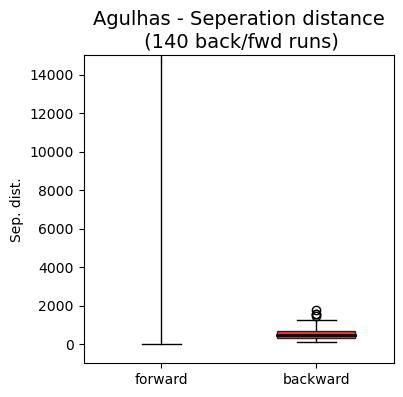

In [162]:
sepdis_back_new_nan = np.array(sepdis_back_new)[~np.isnan(np.array(sepdis_back_new))]
sepdis_fwd_new_nan = np.array(sepdis_fwd_new)[~np.isnan(np.array(sepdis_fwd_new))]

plt.figure(figsize=(4,4))
plt.boxplot(sepdis_back_new_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(sepdis_fwd_new_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Sep. dist.')
plt.title('Agulhas - Seperation distance\n (140 back/fwd runs)', fontsize=14)

plt.ylim([-1000,15000])

Text(0.5, 1.0, 'Agulhas - Seperation distance\n (140 back/fwd runs)')

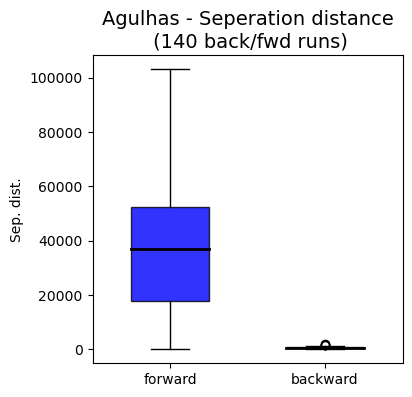

In [163]:
sepdis_back_new_nan = np.array(sepdis_back_new)[~np.isnan(np.array(sepdis_back_new))]
sepdis_fwd_new_nan = np.array(sepdis_fwd_new)[~np.isnan(np.array(sepdis_fwd_new))]

plt.figure(figsize=(4,4))
plt.boxplot(sepdis_back_new_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(sepdis_fwd_new_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Sep. dist.')
plt.title('Agulhas - Seperation distance\n (140 back/fwd runs)', fontsize=14)

#plt.ylim([-100,2500])

In [164]:
n_nan = np.array(n)[~np.isnan(np.array(n))]
n_nan = n_nan[n_nan<450]
np.mean(n_nan)

21.96875

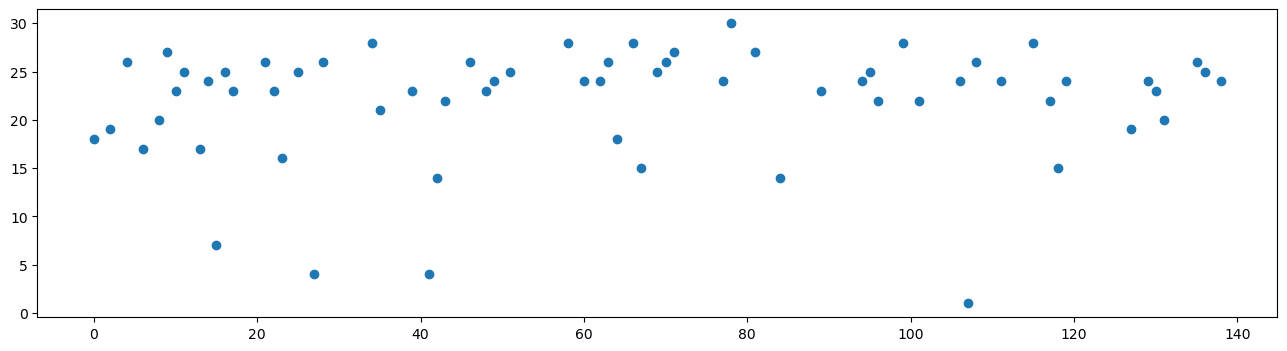

In [165]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(n)),n)
#plt.ylim([0,27])

In [166]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [167]:
hits

array([], dtype=int32)

In [168]:
fwd[13]

<xarray.Dataset>
Dimensions:                                                                              (
                                                                                          trajectory: 12800,
                                                                                          time: 49)
Coordinates:
  * trajectory                                                                           (trajectory) int32 ...
  * time                                                                                 (time) datetime64[ns] ...
Data variables: (12/28)
    status                                                                               (trajectory, time) int32 ...
    moving                                                                               (trajectory, time) int32 ...
    age_seconds                                                                          (trajectory, time) float32 ...
    origin_marker                                                                        (trajectory, time) int32 ...
    lon                                                                                  (trajectory, time) float32 ...
    lat                                                                                  (trajectory, time) float32 ...
    ...                                                                                   ...
    surface_downward_y_stress                                                            (trajectory, time) float32 ...
    turbulent_kinetic_energy                                                             (trajectory, time) float32 ...
    turbulent_generic_length_scale                                                       (trajectory, time) float32 ...
    ocean_mixed_layer_thickness                                                          (trajectory, time) float32 ...
    sea_floor_depth_below_sea_level                                                      (trajectory, time) float32 ...
    land_binary_mask                                                                     (trajectory, time) float32 ...
Attributes: (12/116)
    Conventions:                                                             ...
    standard_name_vocabulary:                                                ...
    featureType:                                                             ...
    history:                                                                 ...
    source:                                                                  ...
    model_url:                                                               ...
    ...                                                                                                               ...
    geospatial_lat_resolution:                                               ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    geospatial_lon_units:                                                    ...
    geospatial_lon_resolution:                                               ...
    runtime:                                                                 ...

In [169]:
sims_back[0]

<xarray.Dataset>
Dimensions:                                                                              (
                                                                                          trajectory: 18,
                                                                                          time: 49)
Coordinates:
  * trajectory                                                                           (trajectory) int32 ...
  * time                                                                                 (time) datetime64[ns] ...
Data variables: (12/28)
    status                                                                               (trajectory, time) int32 ...
    moving                                                                               (trajectory, time) int32 ...
    age_seconds                                                                          (trajectory, time) float32 ...
    origin_marker                                                                        (trajectory, time) int32 ...
    lon                                                                                  (trajectory, time) float32 ...
    lat                                                                                  (trajectory, time) float32 ...
    ...                                                                                   ...
    surface_downward_y_stress                                                            (trajectory, time) float32 ...
    turbulent_kinetic_energy                                                             (trajectory, time) float32 ...
    turbulent_generic_length_scale                                                       (trajectory, time) float32 ...
    ocean_mixed_layer_thickness                                                          (trajectory, time) float32 ...
    sea_floor_depth_below_sea_level                                                      (trajectory, time) float32 ...
    land_binary_mask                                                                     (trajectory, time) float32 ...
Attributes: (12/116)
    Conventions:                                                             ...
    standard_name_vocabulary:                                                ...
    featureType:                                                             ...
    history:                                                                 ...
    source:                                                                  ...
    model_url:                                                               ...
    ...                                                                                                               ...
    geospatial_lat_resolution:                                               ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...
    geospatial_lon_units:                                                    ...
    geospatial_lon_resolution:                                               ...
    runtime:                                                                 ...

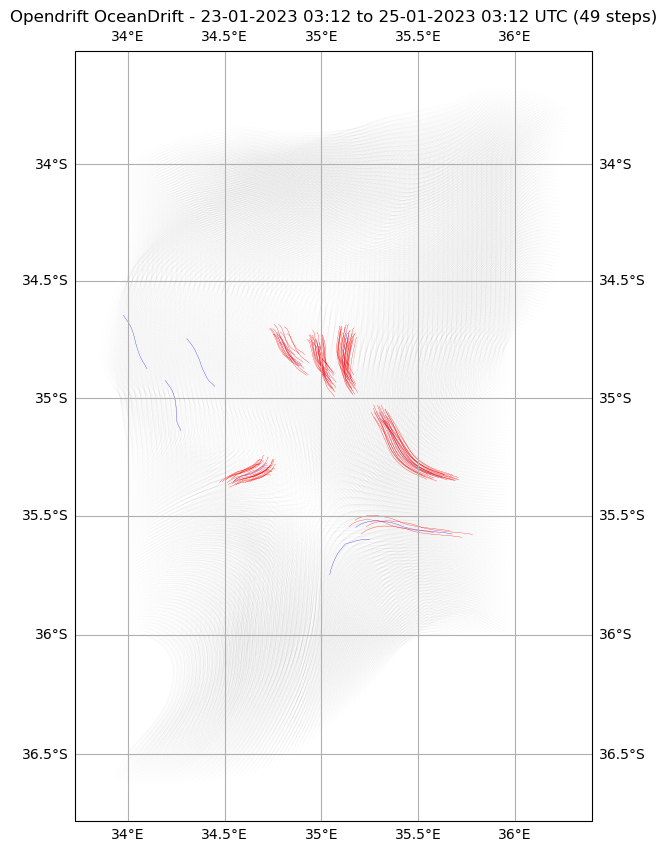

In [170]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

fwd[4].traj.plot(linewidth=0.1, color='grey')

for a in a_traj[40:50]:
    fwd[4].isel(trajectory=a).traj.plot(linewidth=0.2, color='blue')

for b in range(40,50):
    if sims_back[b]>0:
        sims_back[b].traj.plot(linewidth=0.2, color='red')
    
plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

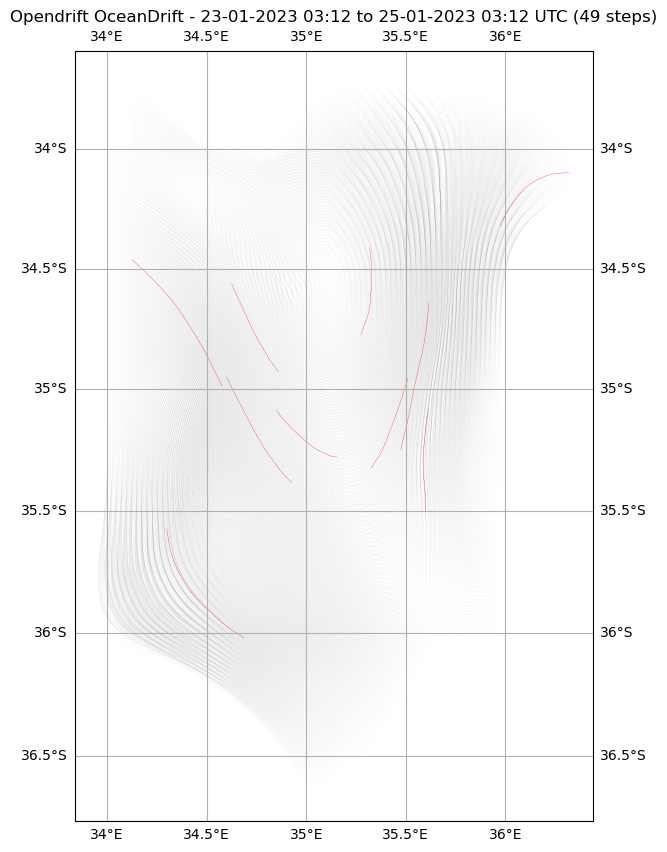

In [34]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

fwd[0].traj.plot(linewidth=0.1, color='grey')

for i in a_traj[0:10]:
    fwd[0].isel(trajectory=i).traj.plot(linewidth=0.2, color='red')
    
plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

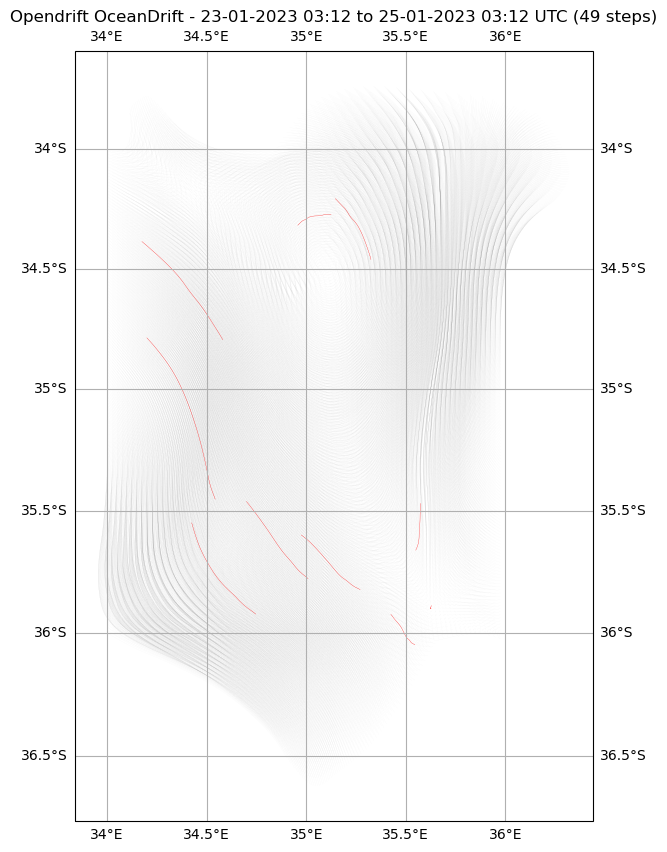

In [36]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

fwd[0].traj.plot(linewidth=0.1, color='grey')

for i in a_traj[10:20]:
    fwd[0].isel(trajectory=i).traj.plot(linewidth=0.2, color='red')
    
plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 